In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:

# Load your CSV
df = pd.read_csv("data.csv")

# Filter out rows with missing Diet
df_training = df[df["Diet"].notna()]

# Select features
features = ["DNE", "positive_DNE", "surface_area", "positive_surface_area"]



In [27]:
# Compute covariance matrices per Diet group
cov_matrices = {}
for diet in df_training["Diet"].unique():
    group_data = df_training[df_training["Diet"] == diet][features]
    cov_matrices[diet] = np.cov(group_data.T)


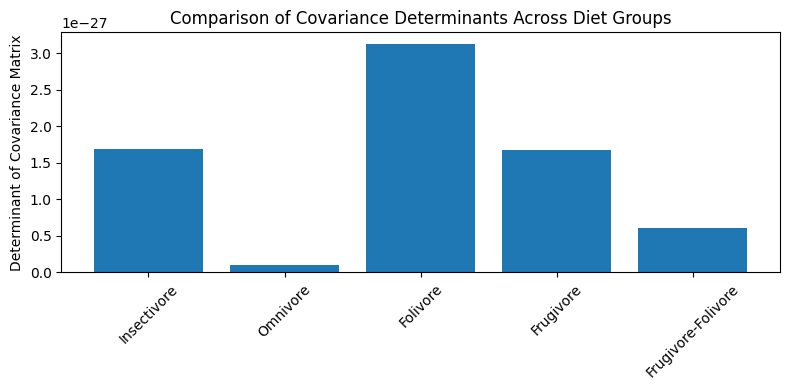

In [28]:
# Compute Determinant
cov_determinants = {diet: np.linalg.det(matrix) for diet, matrix in cov_matrices.items()}

# Plot
plt.figure(figsize=(8, 4))
plt.bar(cov_determinants.keys(), cov_determinants.values())
plt.ylabel("Determinant of Covariance Matrix")
plt.title("Comparison of Covariance Determinants Across Diet Groups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
# Covariance matrices are different so we use QDA

In [30]:
# We can check it with Box's M test to, it compares all features to eachother  if p<0.05 they are different

In [31]:
# Handmade Box test
from scipy.stats import chi2

def box_m_test(X, y):
    classes = np.unique(y)
    n_groups = len(classes)
    n_features = X.shape[1]
    
    pooled_cov = np.cov(X.T)
    pooled_n = len(X)

    M = 0
    total_samples = 0

    for group in classes:
        X_g = X[y == group]
        n_g = len(X_g)
        cov_g = np.cov(X_g.T)
        total_samples += n_g

        M += (n_g - 1) * np.log(np.linalg.det(cov_g))

    M -= (total_samples - n_groups) * np.log(np.linalg.det(pooled_cov))

    # correction faktor (C)
    c = ((2 * n_features**2 + 3 * n_features - 1) *
         (sum([len(X[y == g]) - 1 for g in classes]) - 1)) / (6 * (sum([len(X[y == g]) for g in classes])))

    stat = M * (1 - c)
    df = (n_groups - 1) * n_features * (n_features + 1) / 2
    p_value = 1 - chi2.cdf(stat, df)

    return stat, df, p_value




In [32]:
X_box = df_training[features].values
y_box = df_training["Diet"].values

statistic, dof, p_val = box_m_test(X_box, y_box)
print(f"Box’s M stat: {statistic:.3f}, df: {dof:.0f}, p-value: {p_val:.5f}")


Box’s M stat: 984.510, df: 40, p-value: 0.00000


In [33]:
# So the covariance matrices are extremely separate

In [34]:
# Lettsse the predicted diet for Teilhardina

In [35]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# --- 1. Select training data (samples with known Diet) ---
X_train = df_training[["DNE", "positive_DNE", "surface_area", "positive_surface_area"]]
y_train = df_training["Diet"]

# --- 2. Select samples belonging to the extinct genus Teilhardina ---
df_teilhardina = df[df["Genus"] == "Teilhardina"].copy()
X_teilhardina = df_teilhardina[["DNE", "positive_DNE", "surface_area", "positive_surface_area"]]

# --- 3. Create and train the QDA model ---
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# --- 4. Predict the diet for Teilhardina specimens ---
teilhardina_preds = qda.predict(X_teilhardina)

# --- 5. Store and display the results ---
df_teilhardina["Predicted_Diet"] = teilhardina_preds
df_teilhardina[["DNE", "positive_DNE", "surface_area", "positive_surface_area", "Predicted_Diet"]]


c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is 

,DNE,positive_DNE,surface_area,positive_surface_area,Predicted_Diet
59,0.115921,0.100504,0.001921,0.001621,Frugivore-Folivore
60,0.127262,0.111552,0.001982,0.001677,Frugivore-Folivore
61,0.129335,0.112564,0.001975,0.001682,Frugivore-Folivore
62,0.116759,0.103174,0.001831,0.001556,Omnivore
63,0.116103,0.101067,0.001927,0.001642,Frugivore-Folivore
64,0.134319,0.118678,0.001971,0.001672,Omnivore
65,0.116233,0.104005,0.001920,0.001646,Frugivore-Folivore
66,0.117036,0.102553,0.001881,0.001595,Omnivore


In [36]:
# Letsse on the whole dataset if frugtivore and folivore-fructivore could be merged or not
# Compares the multivariate mean vectors

In [37]:
import numpy as np
from scipy.stats import f

def hotelling_t2_test(X1, X2):
    n1, p = X1.shape
    n2 = X2.shape[0]
    
    mean1 = np.mean(X1, axis=0)
    mean2 = np.mean(X2, axis=0)
    
    pooled_cov = ((n1 - 1) * np.cov(X1.T) + (n2 - 1) * np.cov(X2.T)) / (n1 + n2 - 2)
    diff = mean1 - mean2
    inv_cov = np.linalg.inv(pooled_cov)
    
    T2 = (n1 * n2) / (n1 + n2) * diff.T @ inv_cov @ diff
    
    # Convert to F-distribution
    F_stat = (n1 + n2 - p - 1) * T2 / (p * (n1 + n2 - 2))
    df1 = p
    df2 = n1 + n2 - p - 1
    p_value = 1 - f.cdf(F_stat, df1, df2)
    
    return T2, F_stat, p_value

# --- Select the two groups for comparison ---
X1 = df_training[df_training["Diet"] == "Folivore"][features].values
X2 = df_training[df_training["Diet"] == "Frugivore-Folivore"][features].values

# --- Run the Hotelling’s T² test ---
T2, F_stat, p_val = hotelling_t2_test(X1, X2)

# --- Print the results ---
print(f"Hotelling’s T² statistic: {T2:.3f}")
print(f"F-statistic: {F_stat:.3f}")
print(f"p-value: {p_val:.5f}")

# --- Interpretation of the result ---
if p_val < 0.05:
    print("There is a significant difference between the groups → DO NOT merge them.")
else:
    print("No significant difference → Merging the groups is statistically justifiable.")



Hotelling’s T² statistic: 3.932
F-statistic: 0.865
p-value: 0.50035
No significant difference → Merging the groups is statistically justifiable.


In [39]:
# Create a copy to preserve the original if needed
df_merged = df_training.copy()

# Merge the two diet classes into one
df_merged["Diet"] = df_merged["Diet"].replace("Frugivore-Folivore", "Folivore")

print(df_merged["Diet"].value_counts())

print(df["Diet"].value_counts())



Diet
Folivore       27
Insectivore    25
Omnivore       13
Frugivore       9
Name: count, dtype: int64
Diet
Insectivore           25
Frugivore-Folivore    14
Omnivore              13
Folivore              13
Frugivore              9
Name: count, dtype: int64


In [40]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# --- 1. Merge "Frugivore-Folivore" into "Folivore" ---
df_merged = df_training.copy()
df_merged["Diet"] = df_merged["Diet"].replace("Frugivore-Folivore", "Folivore")

# --- 2. Select features and labels ---
X_train_merged = df_merged[["DNE", "positive_DNE", "surface_area", "positive_surface_area"]]
y_train_merged = df_merged["Diet"]

# --- 3. Select Teilhardina samples for prediction ---
df_teilhardina = df[df["Genus"] == "Teilhardina"].copy()
X_teilhardina = df_teilhardina[["DNE", "positive_DNE", "surface_area", "positive_surface_area"]]

# --- 4. Train the QDA model ---
qda_merged = QuadraticDiscriminantAnalysis()
qda_merged.fit(X_train_merged, y_train_merged)

# --- 5. Predict Teilhardina diet with merged model ---
teilhardina_preds_merged = qda_merged.predict(X_teilhardina)

# --- 6. Save and display the results ---
df_teilhardina["Predicted_Diet_Merged"] = teilhardina_preds_merged
df_teilhardina[["DNE", "positive_DNE", "surface_area", "positive_surface_area", "Predicted_Diet_Merged"]]


c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is 

,DNE,positive_DNE,surface_area,positive_surface_area,Predicted_Diet_Merged
59,0.115921,0.100504,0.001921,0.001621,Folivore
60,0.127262,0.111552,0.001982,0.001677,Folivore
61,0.129335,0.112564,0.001975,0.001682,Folivore
62,0.116759,0.103174,0.001831,0.001556,Omnivore
63,0.116103,0.101067,0.001927,0.001642,Folivore
64,0.134319,0.118678,0.001971,0.001672,Omnivore
65,0.116233,0.104005,0.001920,0.001646,Folivore
66,0.117036,0.102553,0.001881,0.001595,Omnivore


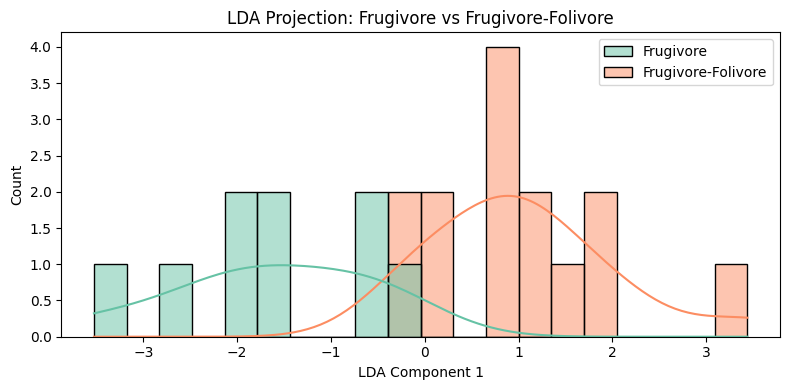

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only Frugivore + Frugivore-Folivore
subset = df_training[df_training["Diet"].isin(["Frugivore", "Frugivore-Folivore"])]
X = subset[features].values
y = subset["Diet"].values

# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X, y)

# Plot the LDA projection
plt.figure(figsize=(8, 4))
sns.histplot(x=X_lda[:, 0], hue=y, bins=20, kde=True, palette="Set2")
plt.title("LDA Projection: Frugivore vs Frugivore-Folivore")
plt.xlabel("LDA Component 1")
plt.tight_layout()
plt.show()


In [62]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, classification_report, accuracy_score
import numpy as np

# --- 1. Prepare data ---
X = df_training[["DNE", "positive_DNE", "surface_area", "positive_surface_area"]].values
y = df_training["Diet"].values

# --- 2. Set up Leave-One-Out CV ---
loo = LeaveOneOut()

# Store predictions for both models
y_true = []
y_pred_logreg = []
y_pred_qda = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Logistic Regression ---
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    logreg.fit(X_train, y_train)
    pred_logreg = logreg.predict(X_test)

    # --- QDA ---
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train, y_train)
    pred_qda = qda.predict(X_test)

    # --- Store all results ---
    y_true.append(y_test[0])
    y_pred_logreg.append(pred_logreg[0])
    y_pred_qda.append(pred_qda[0])

# --- 3. Evaluation ---

print("🧪 Logistic Regression (LOOCV)")
print(f"Accuracy: {accuracy_score(y_true, y_pred_logreg):.3f}")
print(f"Macro F1-score: {f1_score(y_true, y_pred_logreg, average='macro'):.3f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred_logreg))

print("🧪 QDA (LOOCV)")
print(f"Accuracy: {accuracy_score(y_true, y_pred_qda):.3f}")
print(f"Macro F1-score: {f1_score(y_true, y_pred_qda, average='macro'):.3f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred_qda))


c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarnin

🧪 Logistic Regression (LOOCV)
Accuracy: 0.338
Macro F1-score: 0.101

Classification Report:
                    precision    recall  f1-score   support

          Folivore       0.00      0.00      0.00        13
         Frugivore       0.00      0.00      0.00         9
Frugivore-Folivore       0.00      0.00      0.00        14
       Insectivore       0.34      1.00      0.51        25
          Omnivore       0.00      0.00      0.00        13

          accuracy                           0.34        74
         macro avg       0.07      0.20      0.10        74
      weighted avg       0.11      0.34      0.17        74

🧪 QDA (LOOCV)
Accuracy: 0.500
Macro F1-score: 0.441

Classification Report:
                    precision    recall  f1-score   support

          Folivore       0.30      0.23      0.26        13
         Frugivore       0.50      0.33      0.40         9
Frugivore-Folivore       0.22      0.36      0.27        14
       Insectivore       0.84      0.84      0.8

c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is 

In [64]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import f1_score, accuracy_score, classification_report

# --- 1. Load dataset ---
df = pd.read_csv("data.csv")  # Replace with your actual file path

# --- 2. Filter rows with known Diet ---
df_training = df[df["Diet"].notna()]
features = ["DNE", "positive_DNE", "surface_area", "positive_surface_area"]
X = df_training[features].values
y = df_training["Diet"].values

# --- 3. Leave-One-Out Cross-Validation ---
loo = LeaveOneOut()
y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = GaussianNB()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    y_true.append(y_test[0])
    y_pred.append(pred[0])

# --- 4. Evaluate model ---
print(f"LOOCV Accuracy: {accuracy_score(y_true, y_pred):.3f}")
print(f"LOOCV Macro F1-score: {f1_score(y_true, y_pred, average='macro'):.3f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


LOOCV Accuracy: 0.568
LOOCV Macro F1-score: 0.484

Classification Report:
                    precision    recall  f1-score   support

          Folivore       0.00      0.00      0.00        13
         Frugivore       0.70      0.78      0.74         9
Frugivore-Folivore       0.33      0.43      0.38        14
       Insectivore       0.78      0.84      0.81        25
          Omnivore       0.42      0.62      0.50        13

          accuracy                           0.57        74
         macro avg       0.45      0.53      0.48        74
      weighted avg       0.48      0.57      0.52        74



c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\balog\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [66]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import f1_score, accuracy_score, classification_report

# --- 1. Load dataset ---
df = pd.read_csv("data.csv")  # Update if your file has a different name

# --- 2. Filter rows with known Diet ---
df_training = df[df["Diet"].notna()]
features = ["DNE", "positive_DNE", "surface_area", "positive_surface_area"]
X = df_training[features].values
y = df_training["Diet"].values

# --- 3. Leave-One-Out Setup ---
loo = LeaveOneOut()

# --- 4. Evaluate Decision Tree ---
y_true_dt = []
y_pred_dt = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    dt = DecisionTreeClassifier(max_depth=3, random_state=42)
    dt.fit(X_train, y_train)
    y_pred_dt.append(dt.predict(X_test)[0])
    y_true_dt.append(y_test[0])

# --- 5. Evaluate Random Forest ---
y_true_rf = []
y_pred_rf = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf.append(rf.predict(X_test)[0])
    y_true_rf.append(y_test[0])

# --- 6. Report results ---

print("🌳 Decision Tree")
print(f"Accuracy: {accuracy_score(y_true_dt, y_pred_dt):.3f}")
print(f"Macro F1-score: {f1_score(y_true_dt, y_pred_dt, average='macro'):.3f}")
print("\nClassification Report:")
print(classification_report(y_true_dt, y_pred_dt))

print("\n🌲 Random Forest")
print(f"Accuracy: {accuracy_score(y_true_rf, y_pred_rf):.3f}")
print(f"Macro F1-score: {f1_score(y_true_rf, y_pred_rf, average='macro'):.3f}")
print("\nClassification Report:")
print(classification_report(y_true_rf, y_pred_rf))


🌳 Decision Tree
Accuracy: 0.595
Macro F1-score: 0.521

Classification Report:
                    precision    recall  f1-score   support

          Folivore       0.75      0.23      0.35        13
         Frugivore       0.60      0.67      0.63         9
Frugivore-Folivore       0.31      0.57      0.40        14
       Insectivore       0.83      0.96      0.89        25
          Omnivore       0.60      0.23      0.33        13

          accuracy                           0.59        74
         macro avg       0.62      0.53      0.52        74
      weighted avg       0.65      0.59      0.57        74


🌲 Random Forest
Accuracy: 0.595
Macro F1-score: 0.535

Classification Report:
                    precision    recall  f1-score   support

          Folivore       0.62      0.38      0.48        13
         Frugivore       0.64      0.78      0.70         9
Frugivore-Folivore       0.27      0.29      0.28        14
       Insectivore       0.83      0.96      0.89        25

In [68]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# --- 1. Load dataset ---
df = pd.read_csv("data.csv")  # Replace with correct path if needed

# --- 2. Define features and subsets ---
features = ["DNE", "positive_DNE", "surface_area", "positive_surface_area"]

df_training = df[df["Diet"].notna()]                 # Known diets only
df_teilhardina = df[df["Genus"] == "Teilhardina"].copy()  # Teilhardina only

X_train = df_training[features]
y_train = df_training["Diet"]
X_teilhardina = df_teilhardina[features]

# --- 3. Train Decision Tree ---
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_teilhardina)

# --- 4. Train Random Forest ---
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_teilhardina)

# --- 5. Store predictions ---
df_teilhardina["Predicted_Diet_DT"] = dt_preds
df_teilhardina["Predicted_Diet_RF"] = rf_preds

# --- 6. Display results ---
print(df_teilhardina[["Genus"] + features + ["Predicted_Diet_DT", "Predicted_Diet_RF"]])


          Genus       DNE  positive_DNE  surface_area  positive_surface_area  \
59  Teilhardina  0.115921      0.100504      0.001921               0.001621   
60  Teilhardina  0.127262      0.111552      0.001982               0.001677   
61  Teilhardina  0.129335      0.112564      0.001975               0.001682   
62  Teilhardina  0.116759      0.103174      0.001831               0.001556   
63  Teilhardina  0.116103      0.101067      0.001927               0.001642   
64  Teilhardina  0.134319      0.118678      0.001971               0.001672   
65  Teilhardina  0.116233      0.104005      0.001920               0.001646   
66  Teilhardina  0.117036      0.102553      0.001881               0.001595   

     Predicted_Diet_DT   Predicted_Diet_RF  
59            Omnivore            Omnivore  
60            Omnivore            Omnivore  
61            Omnivore            Omnivore  
62            Omnivore            Omnivore  
63            Omnivore            Omnivore  
64  Frugi